## version3: 10/25 –

### Library

In [1]:
# import libraries
import os
import math
import time
import yaml
import datetime 
import numpy as np
import pandas as pd
from tqdm import trange
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.nn import LayerNorm
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

# set random seed
fix_seed = 1111
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)

# set device 
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


### (Load a past model)

In [2]:
'''
This code is used only for loading the model and checking its prediction.
'''
# # set name of the model
# model_num = 20

# # load the model and its loss
# model = torch.load('/Users/koki/PycharmProjects/MasterThesis/models/model_' + str(model_num) + '.pth')
# loss = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='losses', usecols=[model_num-1])
# train_losses = loss.iloc[:,0].to_list()

'\nThis code is used only for loading the model and checking its prediction.\n'

### Import parameters and data

In [3]:
# load parameters
with open('/Users/koki/PycharmProjects/MasterThesis/params/config_transformer.yml', 'r') as yml:
    yaml_data = yaml.safe_load(yml)

In [4]:
# import data
df = pd.read_csv('/Users/koki/PycharmProjects/MasterThesis/data/preprocessed/201601to202309_10areas_for_analysis.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
# choose hours to use
time_list = yaml_data['dataset']['time_list']
if time_list != 'all':
    df = df.loc[df.index.hour.isin(time_list)]

### Define dataset

In [5]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, seq_len_src=56, seq_len_tgt=8, lag_len=8):
        self.seq_len_src = seq_len_src
        self.lag_len = lag_len
        self.seq_len_tgt = seq_len_tgt
        self.df = torch.tensor(dataframe.values).float()
        self.len = math.floor((len(self.df) - self.seq_len_src - self.seq_len_tgt) / self.lag_len) + 1

    def __len__(self):
        return self.len

    def __getitem__(self, i):
        if type(i) == slice:
            raise Exception('Exception: Expected int, inputted slice!')
            
        X = self.df[i*self.lag_len:i*self.lag_len+self.seq_len_src]
        Y = self.df[i*self.lag_len+self.seq_len_src:i*self.lag_len+self.seq_len_src+self.seq_len_tgt]
        
        return X, Y
    
    def input_size(self):
        return self.df.shape[1]

### Split data

In [6]:
# train
train_start = yaml_data['dataset']['train_start']
train_end = yaml_data['dataset']['train_end']

# validation
valid_start = yaml_data['dataset']['valid_start']
valid_end = yaml_data['dataset']['valid_end']

# test
test_start = yaml_data['dataset']['test_start']
test_end = yaml_data['dataset']['test_end']

# split df into train, valid and test data
df_train = df.loc[train_start:train_end].copy()
df_valid = df.loc[train_end:valid_end].copy()  # 検証データの1期目から予測するために、前日もテストデータに含める。
df_test = df.loc[valid_end:test_end].copy()  # テストデータの1期目から予測するために、前日もテストデータに含める。

# print the fraction of each dataset
print("Train set fraction: {:.3f}%".format(len(df_train)/len(df)*100))
print("Valid set fraction: {:.3f}%".format(len(df_valid)/len(df)*100))
print("Test set fraction: {:.3f}%".format(len(df_test)/len(df)*100))

Train set fraction: 96.749%
Valid set fraction: 12.898%
Test set fraction: 9.682%


### Set dataloader

In [7]:
batch_size = yaml_data['dataset']['batch_size']
seq_len_src = yaml_data['dataset']['seq_len_src']
seq_len_tgt = yaml_data['dataset']['seq_len_tgt']
lag_len = yaml_data['dataset']['lag_len']

# create dataset
train_dataset = SequenceDataset(df_train, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=1)
valid_dataset = SequenceDataset(df_valid, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=lag_len)
test_dataset = SequenceDataset(df_test, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=lag_len)
print("Length of each dataset:")
print("    Train:{}, Valid:{}, Test:{}".format(len(train_dataset), len(valid_dataset), len(test_dataset)))

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0, pin_memory=True)

# check the shape of a batch
X, y = next(iter(train_loader))
print("Features shape:", X.shape)  # [batch size, sequence length, number of features]
print("Target shape:", y.shape)

Length of each dataset:
    Train:2737, Valid:364, Test:273
Features shape: torch.Size([64, 5, 66])
Target shape: torch.Size([64, 5, 66])


### Define embedding

In [8]:
#位置エンコーディングの定義
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

#モデルに入力するために次元を拡張することを自然言語処理でいうエンべディングとしました
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model) 

    def forward(self, x):
        x = self.tokenConv(x)
        return x

### Define Transformer

In [9]:
class Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers,
        d_model, d_output,
        dim_feedforward = 512, dropout = 0.1, nhead = 8):
        
        super(Transformer, self).__init__()
        

        #エンべディングの定義
        # self.token_embedding_src = TokenEmbedding(d_input, d_model)
        # self.token_embedding_tgt = TokenEmbedding(d_output, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        #エンコーダの定義
        encoder_layer = TransformerEncoderLayer(d_model=d_model, 
                                                nhead=nhead, 
                                                dim_feedforward=dim_feedforward,
                                                dropout=dropout,
                                                batch_first=True,
                                                activation='gelu'
                                               )
        encoder_norm = LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, 
                                                      num_layers=num_encoder_layers,
                                                      norm=encoder_norm
                                                     )
        
        #デコーダの定義
        decoder_layer = TransformerDecoderLayer(d_model=d_model, 
                                                nhead=nhead, 
                                                dim_feedforward=dim_feedforward,
                                                dropout=dropout,
                                                batch_first=True,
                                                activation='gelu'
                                               )
        decoder_norm = LayerNorm(d_model)
        self.transformer_decoder = TransformerDecoder(decoder_layer, 
                                                      num_layers=num_decoder_layers, 
                                                      norm=decoder_norm)
        
        #出力層の定義
        self.output = nn.Linear(d_model, d_output)
        

    def forward(self, src, tgt, mask_src, mask_tgt):
        #mask_src, mask_tgtはセルフアテンションの際に未来のデータにアテンションを向けないためのマスク
        
        embedding_src = self.positional_encoding(src)
        memory = self.transformer_encoder(embedding_src, mask_src)
        
        embedding_tgt = self.positional_encoding(tgt)
        outs = self.transformer_decoder(embedding_tgt, memory, mask_tgt)
        
        output = self.output(outs)
        return output

    def encode(self, src, mask_src):
        return self.transformer_encoder(self.positional_encoding(src), mask_src)

    def decode(self, tgt, memory, mask_tgt):
        return self.transformer_decoder(self.positional_encoding(tgt), memory, mask_tgt)


### Define masks

In [10]:
def create_mask(src, tgt):
    
    seq_len_src = src.shape[1]
    seq_len_tgt = tgt.shape[1]

    mask_tgt = generate_square_subsequent_mask(seq_len_tgt).to(device)
    mask_src = generate_square_subsequent_mask(seq_len_src).to(device)

    return mask_src, mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
    return mask


### Define training, validation, and prediction

In [11]:
def train(model, data_loader, optimizer, criterion, num_features_pred, loss_calculation):
    model.train()
    total_loss = []
    for src, tgt in data_loader:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        input_tgt = torch.cat((src[:,-1:,:],tgt[:,:-1,:]), dim=1)
        
        mask_src, mask_tgt = create_mask(src, input_tgt)
        
        output = model(src=src, tgt=input_tgt, mask_src=mask_src, mask_tgt=mask_tgt)
        
        optimizer.zero_grad()
        
        if loss_calculation == 'all':
            loss = criterion(output, tgt)
        elif loss_calculation == 'features_pred':
            loss = criterion(output[:,:,0:num_features_pred], tgt[:,:,0:num_features_pred])
        
        loss.backward()
        total_loss.append(loss.cpu().detach())
        optimizer.step()
        
    return np.average(total_loss)


def validate(model, data_loader, criterion, num_features_pred, loss_calculation):
    model.eval()
    total_loss = []
    for src, tgt in data_loader:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        seq_len_src = src.shape[1]
        
        mask_src = (torch.zeros(seq_len_src, seq_len_src)).type(torch.bool)
        mask_src = mask_src.float().to(device)
    
        memory = model.encode(src, mask_src)
        outputs = src[:, -1:, :]
        seq_len_tgt = tgt.shape[1]
    
        # ループさせて逐次的に予測する
        for i in range(seq_len_tgt - 1):  # 1期目を入力し2期目以降を予測するので、seq_len_tgt-1する。
        
            mask_tgt = (generate_square_subsequent_mask(outputs.size(1))).to(device)
        
            output = model.decode(outputs, memory, mask_tgt)
            output = model.output(output)
            
            # concat predicted population and actual dummies
            output = torch.cat([output[:, -1:, :num_features_pred], tgt[:, i+1:i+2, num_features_pred:]], dim=2)

            outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)
                
        if loss_calculation == 'all':
            loss = criterion(outputs, tgt)
        elif loss_calculation == 'features_pred':
            loss = criterion(outputs[:,:,0:num_features_pred], tgt[:,:,0:num_features_pred])
        
        total_loss.append(loss.cpu().detach())
        
    return np.average(total_loss)


def predict(model, test_dataset, num_features_pred):
    model.eval()
    with torch.no_grad():
        all_outputs = torch.zeros(1, 1, df.shape[1]).to(device)
        for t in tqdm(range(len(test_dataset))):  # (len(df_test)-8)/8 = 92回予測が必要
            src = test_dataset[t][0].float().to(device)
            tgt = test_dataset[t][1].float().to(device)

            # add a batch size of 1 for the encoder (= [1, :, :])
            src = src.unsqueeze(0)  
            tgt = tgt.unsqueeze(0)

            seq_len_src = src.shape[1]
            seq_len_tgt = tgt.shape[1]
            
            mask_src = (torch.zeros(seq_len_src, seq_len_src)).type(torch.bool)
            mask_src = mask_src.float().to(device)
            
            memory = model.encode(src, mask_src)
            outputs = src[:, -1:, :]

            #ループさせて逐次的に予測する
            for i in range(seq_len_tgt):

                mask_tgt = (generate_square_subsequent_mask(outputs.size(1))).to(device)

                output = model.decode(outputs, memory, mask_tgt)
                output = model.output(output)  # output.shape = [バッチサイズ1, ウィンドウサイズi(累積される), 変数]

                # convert predicted dummies to the actual ones
                output = torch.cat([output[:, -1:, :num_features_pred], tgt[:, i:i+1, num_features_pred:]], dim=2)

                # concat outputs and output above
                outputs = torch.cat([outputs, output], dim=1)
                
            all_outputs = torch.cat([all_outputs, outputs[:, 1:, :]], dim=1)

    return all_outputs[-1, 1:, :num_features_pred]  # all_outputs[-1, 1:, :num_features_pred] → バッチサイズを消す＆all_outputsの最初の0を消す

### Define parameters

In [13]:
# d_input = 1
d_output = train_dataset.input_size()
d_model = train_dataset.input_size()
nhead = yaml_data['model']['nhead'] 
dim_feedforward = yaml_data['model']['dim_feedforward']
num_encoder_layers = yaml_data['model']['num_encoder_layers']
num_decoder_layers = yaml_data['model']['num_decoder_layers']
dropout = yaml_data['model']['dropout']
epochs = yaml_data['training']['n_epochs']
learning_rate = yaml_data['training']['learning_rate']
num_features_pred=yaml_data['training']['num_features_pred']
loss_calculation=yaml_data['training']['loss_calculation']
best_loss = float('Inf')
best_model = None

model = Transformer(num_encoder_layers=num_encoder_layers,
                    num_decoder_layers=num_decoder_layers,
                    d_model=d_model,
                    d_output=d_output,
                    dim_feedforward=dim_feedforward,
                    dropout=dropout, nhead=nhead)

# for p in model.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

model = model.to(device)
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

In [15]:
start = time.time()

train_losses = []
valid_losses = []
with trange(epochs) as tr:
    for epoch in tr:
        # train
        loss_train = train(model=model, 
                           data_loader=train_loader, 
                           optimizer=optimizer,
                           criterion=criterion, 
                           num_features_pred=num_features_pred, 
                           loss_calculation=loss_calculation)
        # # validation
        # loss_valid = validate(model=model, 
        #                       data_loader=valid_loader, 
        #                       criterion=criterion, 
        #                       num_features_pred=num_features_pred, 
        #                       loss_calculation=loss_calculation)

        # convert to RMSE
        loss_train = math.sqrt(loss_train)
        # loss_valid = math.sqrt(loss_valid)
        
        train_losses.append(loss_train)
        # valid_losses.append(loss_valid)
        
#         # record the best loss and the model 
#         if best_loss > loss_valid:
#             best_loss = loss_valid
#             best_model = model
            
        # progress bar 
        # tr.set_postfix({"Train_loss":"{:.3f}".format(loss_train), "Valid_loss":"{:.3f}".format(loss_valid)})
        tr.set_postfix(Train_loss="{0:.3f}".format(loss_train))

end = time.time()
t = math.floor(end-start)

elapsed_hour = t // 3600
elapsed_minute = (t % 3600) // 60
elapsed_second = (t % 3600 % 60)

elapsed_time = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)

100%|████████████████████████████████████████████| 1300/1300 [1:14:52<00:00,  3.46s/it, Train_loss=20864.116, Valid_loss=19277.303]


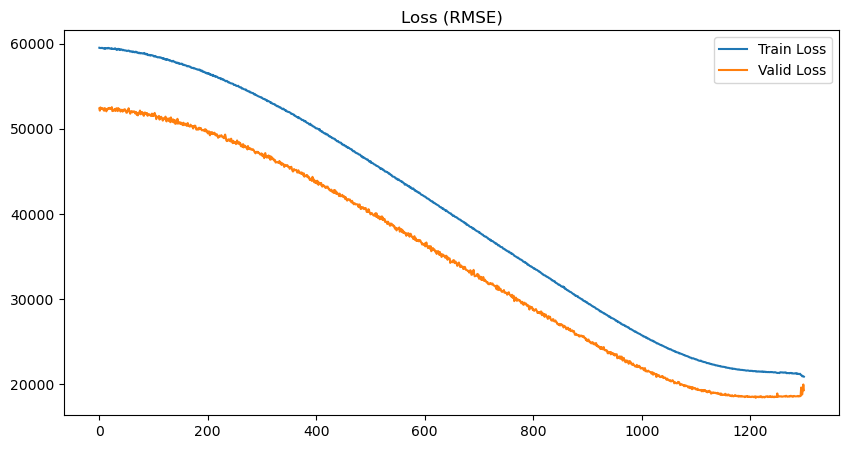

In [16]:
# plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Valid Loss')
plt.title('Loss (RMSE)')
plt.legend()
plt.show()

### (Predict in test data)

In [17]:
# evaluate(model=model, data_loader=test_loader, criterion=criterion)

### Predict

In [18]:
# make y_true df
y_true = df_valid.iloc[seq_len_tgt:, 0:num_features_pred]

# make y_pred df
pred = predict(model=model, data_loader = valid_loader, num_features_pred = num_features_pred).cpu()
y_pred = pd.DataFrame(pred, columns=df.columns[0:num_features_pred], index=y_true.index).add_prefix('pred_')

  0%|          | 0/273 [00:00<?, ?it/s]

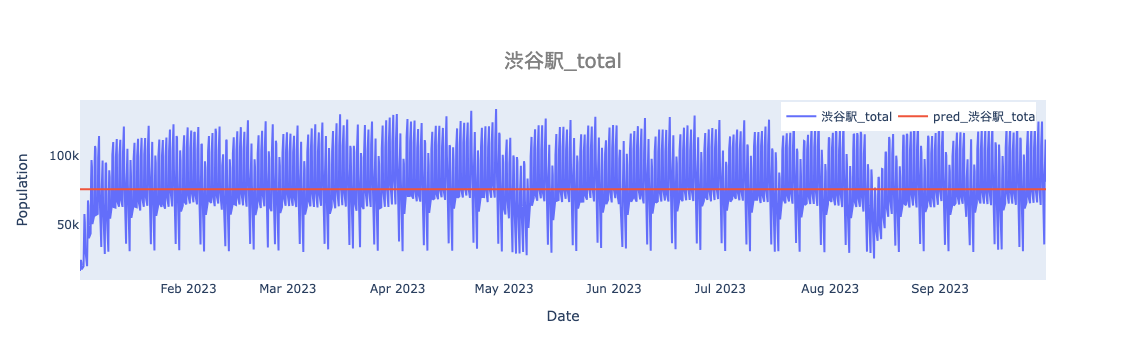

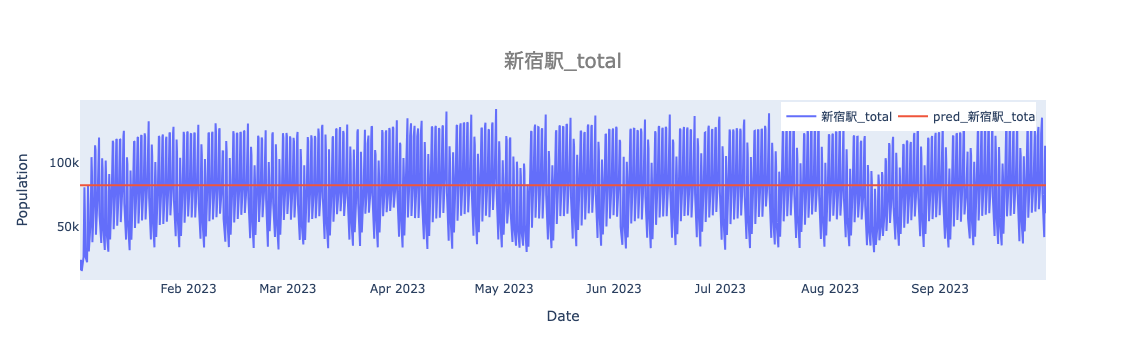

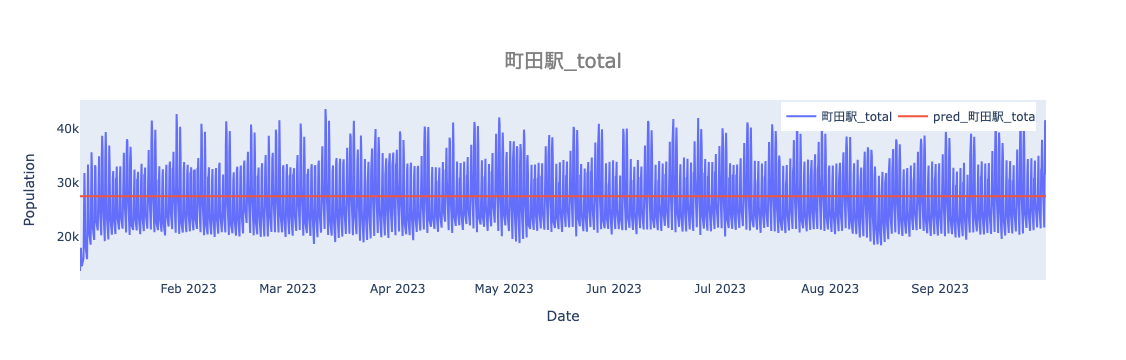

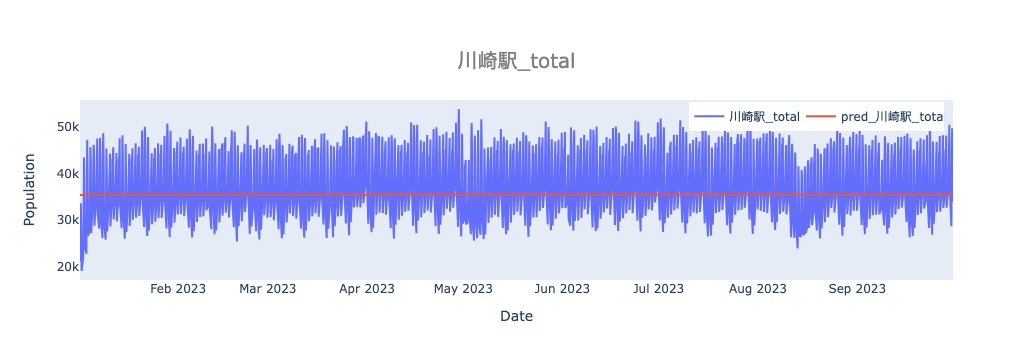

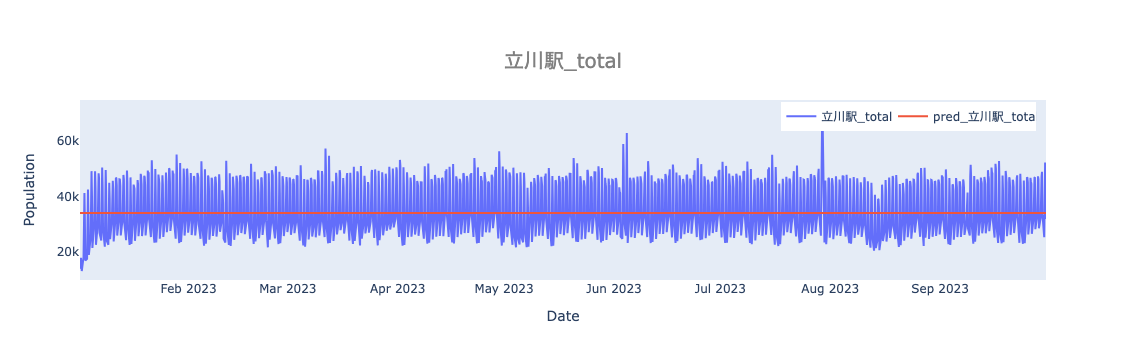

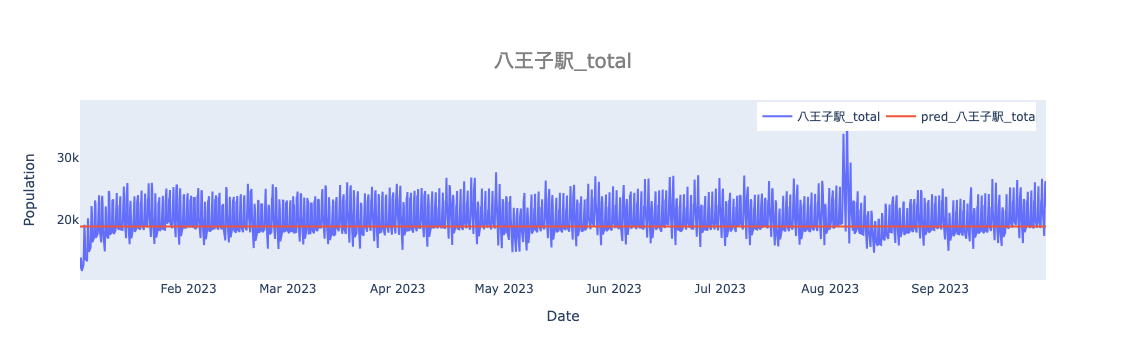

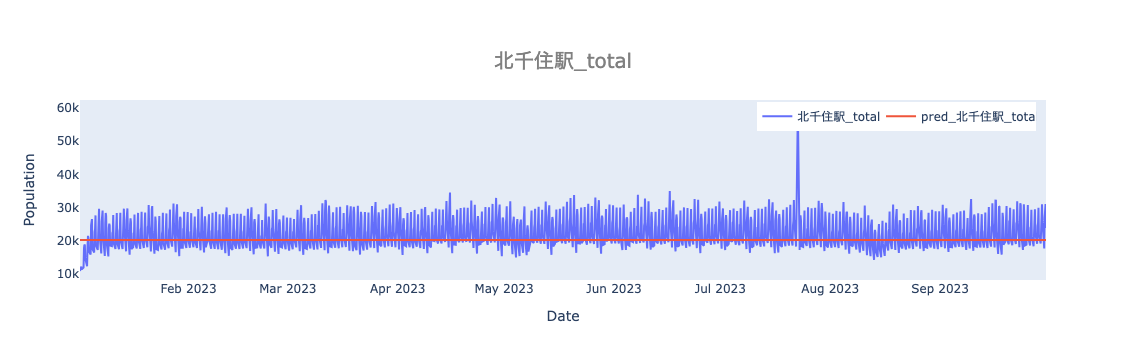

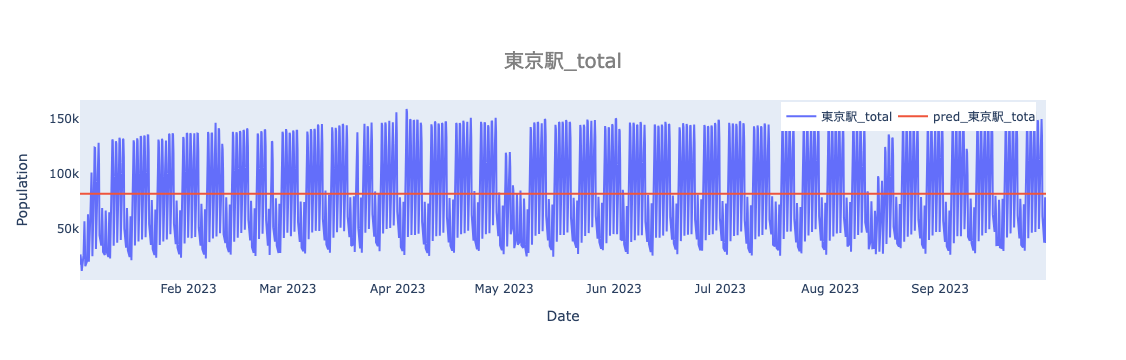

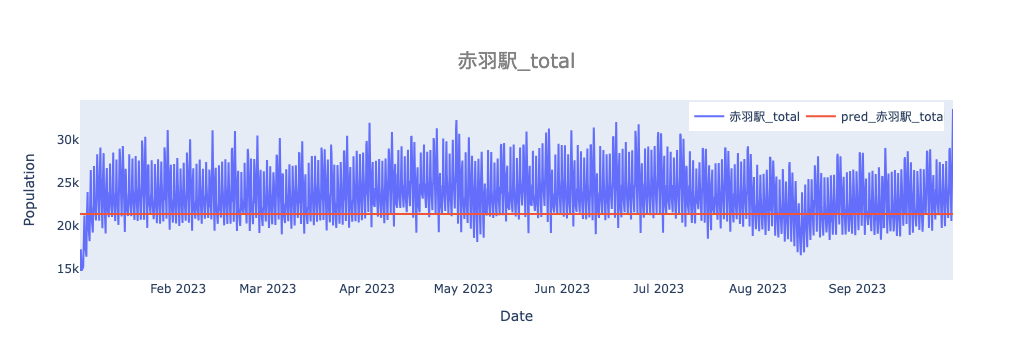

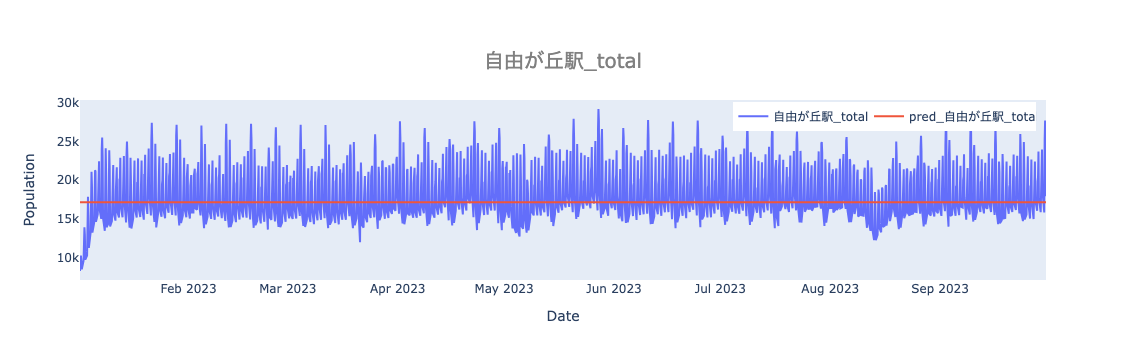

In [19]:
# plot with plotly     
for i in range(y_pred.shape[1]):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true.index, y=y_true.iloc[:, i], name=y_true.columns[i]))
    fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred.iloc[:, i], name=y_pred.columns[i]))
    fig.update_xaxes(title="Date",showgrid=False)
    fig.update_yaxes(title="Population", showgrid=False)
    fig.update_layout(legend=dict(x=0.99,
                              y=0.99,
                              xanchor='right',
                              yanchor='top',
                              orientation='h',
                              ),
                      hovermode='x unified',
                      title=dict(text=y_true.columns[i],
                                 font=dict(size=20, color='grey'),
                                 xref='paper', # container or paper
                                 x=0.5,
                                 y=0.85,
                                 xanchor='center'
                                )
                     )
    fig.show()

### Calculate MSE and MAE by actual values

In [20]:
print('------------MSE------------')
mse = []
for i in range(y_true.shape[1]):
    mse.append(mean_squared_error(y_true.iloc[:,i], y_pred.iloc[:,i], squared=False))
    print(y_true.columns[i], ':', mse[i])
print('Average :', np.mean(mse))
    
print('------------MAE------------')
mae= []
for i in range(y_true.shape[1]):
    mae.append(mean_absolute_error(y_true.iloc[:,i], y_pred.iloc[:,i]))
    print(y_true.columns[i], ':', mae[i])
print('Average :', np.mean(mae))

------------MSE------------
渋谷駅_total : 29232.784866505528
新宿駅_total : 32342.96500162857
町田駅_total : 6392.538298902937
川崎駅_total : 8435.370842273376
立川駅_total : 10781.088540856807
八王子駅_total : 3723.0927974273022
北千住駅_total : 5710.328471326064
東京駅_total : 43494.10240411682
赤羽駅_total : 4186.70873969887
自由が丘駅_total : 4167.477206325969
Average : 14846.645716906223
------------MAE------------
渋谷駅_total : 24764.877901785716
新宿駅_total : 28179.985113324175
町田駅_total : 5657.100187442766
川崎駅_total : 7439.76901614011
立川駅_total : 9704.480028044873
八王子駅_total : 3106.4140124198716
北千住駅_total : 4610.125065819597
東京駅_total : 39636.98503891941
赤羽駅_total : 3381.45030191163
自由が丘駅_total : 3437.318137591575
Average : 12991.850480339972


### Calculate RMSE and MAE by benchmark

In [51]:
# test_dataの直近4週間のデータを抽出
df_valid.iloc[-28*tgt_length:,:num_features_pred]

渋谷駅_total  新宿駅_total  町田駅_total  川崎駅_total  \
datetime                                                                
2022-12-04 09:00:00+00:00      31262      33450      20774      26514   
2022-12-04 12:00:00+00:00      79677      84293      35502      42533   
2022-12-04 15:00:00+00:00     101453     102260      38934      47814   
2022-12-04 18:00:00+00:00      94991      85602      33940      40747   
2022-12-05 09:00:00+00:00      62954      86453      21399      34867   
...                              ...        ...        ...        ...   
2022-12-30 18:00:00+00:00      83180      79195      36053      39756   
2022-12-31 09:00:00+00:00      21655      27050      17457      22700   
2022-12-31 12:00:00+00:00      42098      53887      27358      34697   
2022-12-31 15:00:00+00:00      49873      59899      29020      36904   
2022-12-31 18:00:00+00:00      40391      38396      21421      28740   

                           立川駅_total  八王子駅_total  北千住駅_total  東京駅_total  \
datetime                                                                  
2022-12-04 09:00:00+00:00      22344       15756       16003      30602   
2022-12-04 12:00:00+00:00      44592       22554       25152      62677   
2022-12-04 15:00:00+00:00      50649       23858       27002      72353   
2022-12-04 18:00:00+00:00      41306       22636       25200      59548   
2022-12-05 09:00:00+00:00      32475       18973       18169     107533   
...                              ...         ...         ...        ...   
2022-12-30 18:00:00+00:00      42565       21633       27576      60925   
2022-12-31 09:00:00+00:00      19501       13573       13899      30641   
2022-12-31 12:00:00+00:00      33565       18583       21195      57356   
2022-12-31 15:00:00+00:00      34989       18763       22434      51872   
2022-12-31 18:00:00+00:00      23695       15937       16628      30382   

                           赤羽駅_total  自由が丘駅_total  
datetime                                           
2022-12-04 09:00:00+00:00      19165        14014  
2022-12-04 12:00:00+00:00      24082        23800  
2022-12-04 15:00:00+00:00      25504        25468  
2022-12-04 18:00:00+00:00      25221        19833  
2022-12-05 09:00:00+00:00      20907        14947  
...                              ...          ...  
2022-12-30 18:00:00+00:00      26924        18861  
2022-12-31 09:00:00+00:00      17412        10497  
2022-12-31 12:00:00+00:00      21639        14413  
2022-12-31 15:00:00+00:00      22346        14609  
2022-12-31 18:00:00+00:00      19285        11766  

[112 rows x 10 columns]

In [52]:
dow = ['dow_Mon','dow_Tue','dow_Wed','dow_Thu','dow_Fri','dow_Sat', 'dow_Sun']
d = dow[y_pred.index[0].weekday()]

NameError: name 'y_pred' is not defined

In [ ]:


# get df for the past one month
b_start = (datetime.datetime.strptime(test_start, '%Y-%m-%d') + datetime.timedelta(days=-30)).strftime('%Y-%m-%d %H:%M:%S')
b_end = (datetime.datetime.strptime(test_start, '%Y-%m-%d') + datetime.timedelta(hours=-3)).strftime('%Y-%m-%d %H:%M:%S')
benchmark_daterange = pd.date_range(start=b_start, end=b_end, freq='3H')
_df = df.loc[benchmark_daterange[0]:benchmark_daterange[-1]]

# calculate RMSE (y_true = the mean of the past one month, y_pred = the mean of all the predicted values)
dow = ['dow_Mon','dow_Tue','dow_Wed','dow_Thu','dow_Fri','dow_Sat', 'dow_Sun']
d = dow[y_pred.index[0].weekday()]
bench = mean_absolute_error(_df[_df[d]==1].mean()[:num_features_pred], y_pred.iloc[:,:num_features_pred].mean())
print(d, 'RMSE: ', mean_squared_error(_df[_df[d]==1].mean()[:num_features_pred], y_pred.iloc[:,:num_features_pred].mean(), squared=False))
print(d, 'MAE: ', bench)
print('absolute_error')
for i in range(y_true.shape[1]):
    print(f'   {y_true.columns[i]}: {np.abs(_df[_df[d]==1].mean()[:num_features_pred][i] - y_pred.iloc[:,:num_features_pred].mean()[i])}')

In [21]:
bench=0

### Save the results and the model

In [22]:
'''
save the model, its loss, and params used
'''
# count the number of files in the directory
path = '/Users/koki/PycharmProjects/MasterThesis/models'
# num = sum(os.path.isfile(os.path.join(path, name)) for name in os.listdir(path))

# read parameter data
df1 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='params')

# set a model name
num = 'model_' + str(df1.shape[0]+1).zfill(2)

# get params used in this file
series = pd.concat([pd.Series(yaml_data['dataset']), pd.Series(yaml_data['model']), pd.Series(yaml_data['training'])])
params = pd.DataFrame(series).T
params.insert(0, "num", num)
params.insert(1, "file_name", "Transformer_ver2")  ###### the name of this file! ######
params.insert(2, "date_of_execution", datetime.datetime.today().strftime("%Y-%m-%d %H:%M"))
params.insert(3, "execution_time", elapsed_time)
params.insert(params.shape[1], "final_train_loss" , math.floor(train_losses[-1]))
params.insert(params.shape[1], "final_valid_loss" , math.floor(valid_losses[-1]))
params.insert(params.shape[1], "mse_observation" , math.floor(np.mean(mse)))
params.insert(params.shape[1], "mae_observation" , math.floor(np.mean(mae)))
params.insert(params.shape[1], "mae_benchmark" , math.floor(bench))
df1 = pd.concat([df1, params])

# read train loss data
df2 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='train_losses')
df2 = pd.concat([df2, pd.Series(train_losses, name=num)], axis=1)

# read valid loss data
df3 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='valid_losses')
df3 = pd.concat([df3, pd.Series(valid_losses, name=num)], axis=1)

# export the data 
with pd.ExcelWriter('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx') as writer:
    df1.to_excel(writer, sheet_name='params', index=False)
    df2.to_excel(writer, sheet_name='train_losses', index=False)
    df3.to_excel(writer, sheet_name='valid_losses', index=False)

# save the model
torch.save(model.state_dict(), '/Users/koki/PycharmProjects/MasterThesis/models/' + num + '.pth')

In [23]:
# notification
# !afplay '/Users/koki/Documents/セレナと一緒/result_message.m4a'

In [24]:
print("Done!!!")

Done!!!


### Memo

In [ ]:
'''
seq2seqも初期のlstmみたいにダミーを後から線形結合してみる？
positional encodingなど必要かどうかちゃんと検証する必要あり。
もっと時系列予測の論文調べる
リアルタイムに予想するなら、新たな学習データを使ってファインチューニングする？
やっぱりもっとちゃんとtrain,valid,testの分割を考えないと、統計量が違いすぎるかも。


train: 2016/01 – 2021/12 学習
valid: 2022/01 – 2022/12　予測値とベンチマークを比較、予測値と実測値を比較、mseを計算
test: 2023/01 – 2023/09　異常検知

ベンチマーク
 1. trainの1月の曜日ごとの平均を計算（7個の値が出てくる）（祝日等は人流が変わるので抜いて計算）
 2. それをベンチマークから作った1月の予測値とする
 3. 各月について1と2を繰り返す
 
学習用とテスト用でデータセットの作り方を変える
seq_len_src=56の場合
学習用：1期ずつずらしていく
        src: t=1–56, tgt: t=57-64
             t=2-57,      t=58-65
テスト用：1日ずつずらしていく
        src: t=1–56, tgt: t=57-64
             t=9-64,      t=65–72
             
seq_len_src=8の場合
学習用：1期ずつずらしていく
        src: t=1–8, tgt: t=9-16
             t=2-9,      t=10-17
テスト用：1日ずつずらしていく
        src: t=1–8, tgt: t=9-16
             t=9-16,     t=17–24 
             
seq_len_src=28の場合
学習用：1期ずつずらしていく
        src: t=1–28, tgt: t=29-32
             t=2-29,      t=30-33
テスト用：1日ずつずらしていく
        src: t=1–28, tgt: t=29-32
             t=5-32,      t=33–36 
             
[seq2seq]
学習の仕方：
 t=1–8→encoder, t=8,9-15→decoder→t=9-16→loss計算,
 
テストの仕方：
 t=1–8→encoder, t=8→decoder→t=9→decoder→t=10→...→t=15→decoder→t=16

[lstm]
学習の仕方：
 t=1–8→lstm→t=2-9→loss計算,
 
テストの仕方：
 t=1–8→lstm→t=9→lstm→t=10→...→t=16→lstm→t=17

'''

### Questions

In [ ]:
'''
3ヶ月予測は、データセットのtime_stepを3ヶ月に作り直すのか、それとも今のままでただ3ヶ月分予測するだけか。
 - データセットはそのままで、ただ3ヶ月先まで予測すれば良いだけ。
   9/1（t=1,...,8）を入力して9/2（t=9,...,16）を予測したら、次はその予測された9/2（t=9,...,16）を入力して9/3（t=17,...,24）を予測する。
 
lstmの予測はループさせるの？
 - yes
 - 単純なlstmの場合、（t=1,...,8）を入力するとそれぞれの値の一期先（t=2,...,9）を出力するだけなので、やはりループが必要。
　
loss計算を人流だけで行うのは本当に正しい？
 - yes
 - 人流以外を予測するのは理にかなってない。（そうなるとn225も外すべきかも）

異常検知はただ予測値と実測値の差を求めて、それが閾値を超えてたら異常と判断すれば良いの？
 - yes
 - 異常検知の場合validも作る　train:2016-2021, valid:2021-2022, test:2023/01/-2023/09
 - 東京の異常を見るときは、数字を一つにまとめる。（二次形式を作り、validdataの平均分散を用いて計算する。詳しくは写真を参照のこと。）
 - time stepの数を減らす（e.g., 朝昼夕の3期）
 
ベンチマークの作りかたをもっと詳しく
 - 
 
コロナ関連のイベントダミーの作り方（e.g., ワクチン開発された、など）はどう作る。その日以降がずっと1になる？それともその日だけ1？
 - 

validationの使い道
 - 


'''

### Insight

In [ ]:
'''
学習率は0.0001じゃないとダメそう。
バッチが大きいとエポックの進みは早いが学習率を小さくしないと上手くいかず、結果的に収束するまで時間がかかる。
バッチが小さいと学習率は比較的大きくて大丈夫だが、学習が遅い。
'''

### To Do

In [ ]:
'''
コロナダミー作成 done
コロナ関連のイベントダミー作成 done
seq2seq, lstmのコードもいじる
時間によって変わる経済変数をもっと入れる（犯罪数、ドル円レート）
データを2016-2023に増やす done
3ヶ月くらい予測してmseで比較 done
長期予測と比較できるようにbenchmarkを作り直す
訓練データ内にある災害などの日を見て、そこが異常検知できてるかどうか見てみる。
予測値を使って異常検知
リアルタイムに異常検知できるようにする
学習の実行時間もエクセルに載せたい done
'''